# Custom Training of Horses or Humans dataset in Graph mode
dataset: [horses_or_humans](https://www.tensorflow.org/datasets/catalog/horses_or_humans)


Note: Need running in Colab

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import matplotlib.pyplot as plt

## Prepare dataset

In [2]:
splits, info = tfds.load("horses_or_humans", data_dir='./data', with_info=True, as_supervised=True,
                         split=["train[:80%]","train[80%:]","test"])
(train_examples, val_examples, test_examples) = splits
info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Shuffling data/horses_or_humans/3.0.0.incompleteQ5TX8W/horses_or_humans-train.tfrecord*...:   0%|          | 0…

Generating test examples...:   0%|          | 0/256 [00:00<?, ? examples/s]

Shuffling data/horses_or_humans/3.0.0.incompleteQ5TX8W/horses_or_humans-test.tfrecord*...:   0%|          | 0/…

Dataset horses_or_humans downloaded and prepared to ./data/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='horses_or_humans',
    full_name='horses_or_humans/3.0.0',
    description="""
    A large set of images of horses and humans.
    """,
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    data_dir=PosixGPath('/tmp/tmpr_c9q5xhtfds'),
    file_format=tfrecord,
    download_size=153.59 MiB,
    dataset_size=153.53 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=256, num_shards=1>,
        'train': <SplitInfo num_examples=1027, num_shards=2>,
    },
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/horses-or-humans-dataset"
    }""",
)

In [3]:
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [4]:
batch_size = 32
image_size = 224

## Preproce image

In [5]:
@tf.function
def map_fn(image, label):
    img_h=224
    img_w=224
    img = tf.image.resize(image, (img_h, img_w))
    img /= 255.
    return img, label

In [6]:
## TEST CODE:

test_image, test_label = list(train_examples)[0]

test_result = map_fn(test_image, test_label)

print(test_result[0].shape)
print(test_result[1].shape)

del test_image, test_label, test_result

(224, 224, 3)
()


## Preprocess datasets

In [7]:
len(train_examples)

822

In [8]:
def prepare_ds(train_examples, val_examples, test_examples,
              map_fn, num_examples, batch_size):

    train_ds = train_examples.map(map_fn).shuffle(num_examples).batch(batch_size)
    val_ds = val_examples.map(map_fn).batch(batch_size)
    test_ds = test_examples.map(map_fn).batch(batch_size)
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = prepare_ds(train_examples, val_examples, test_examples,
              map_fn, num_examples, batch_size)

In [10]:
## TEST CODE:

test_train_ds = list(train_ds)
print(len(test_train_ds))
print(test_train_ds[0][0].shape)

del test_train_ds

26
(32, 224, 224, 3)


## Define a model

In [11]:
num_classes

2

In [15]:
#need to upload the model file
##MODULE_HANDLE = 'resnet_50_feature_vector'
#model_handle = hub.load(MODULE_HANDLE)
#option_download_online
model_handle = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'
hub_layer = hub.KerasLayer(model_handle, input_shape=(image_size, image_size, 3))
print(isinstance(hub_layer, tf.keras.layers.Layer)) #should output: True

True


In [16]:
model = tf.keras.Sequential()
model.add(hub.KerasLayer(model_handle, input_shape=(image_size, image_size, 3)))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23568898 (89.91 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


## Define optimizer
Define the [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) that is in the tf.keras.optimizers module.

In [17]:
def set_adam_optimizer():

    # Define the adam optimizer
    optimizer = tf.keras.optimizers.Adam()

    return optimizer

In [18]:
## TEST CODE:

test_optimizer = set_adam_optimizer()

print(type(test_optimizer))

del test_optimizer

<class 'keras.src.optimizers.adam.Adam'>


## Define the loss function

Define the loss function as the [sparse categorical cross entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) that's in the tf.keras.losses module.  Use the same function for both training and validation.

In [19]:
def set_sparse_cat_crossentropy_loss():

    # Define object oriented metric of Sparse categorical crossentropy for train and val loss
    train_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    val_loss = tf.keras.losses.SparseCategoricalCrossentropy()

    return train_loss, val_loss

In [20]:
## TEST CODE:

test_train_loss, test_val_loss = set_sparse_cat_crossentropy_loss()

print(type(test_train_loss))
print(type(test_val_loss))

del test_train_loss, test_val_loss

<class 'keras.src.losses.SparseCategoricalCrossentropy'>
<class 'keras.src.losses.SparseCategoricalCrossentropy'>


## Define the acccuracy function
Define the accuracy function as the [spare categorical accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalAccuracy) that's contained in the tf.keras.metrics module.   Use the same function for both training and validation.

In [21]:
def set_sparse_cat_crossentropy_accuracy():

    # Define object oriented metric of Sparse categorical accuracy for train and val accuracy
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    return train_accuracy, val_accuracy

In [22]:
## TEST CODE:

test_train_accuracy, test_val_accuracy = set_sparse_cat_crossentropy_accuracy()

print(type(test_train_accuracy))
print(type(test_val_accuracy))

del test_train_accuracy, test_val_accuracy

<class 'keras.src.metrics.accuracy_metrics.SparseCategoricalAccuracy'>
<class 'keras.src.metrics.accuracy_metrics.SparseCategoricalAccuracy'>


In [23]:
optimizer = set_adam_optimizer()
train_loss, val_loss = set_sparse_cat_crossentropy_loss()
train_accuracy, val_accuracy = set_sparse_cat_crossentropy_accuracy()

## Define the training loop

In [24]:
# this code uses the GPU if available, otherwise uses a CPU
device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'
EPOCHS = 2

# Custom training step
def train_one_step(model, optimizer, x, y, train_loss, train_accuracy):
    '''
    Trains on a batch of images for one step.

    Args:
        model (keras Model) -- image classifier
        optimizer (keras Optimizer) -- optimizer to use during training
        x (Tensor) -- training images
        y (Tensor) -- training labels
        train_loss (keras Loss) -- loss object for training
        train_accuracy (keras Metric) -- accuracy metric for training
    '''
    with tf.GradientTape() as tape:

        # Run the model on input x to get predictions
        predictions = model(x)
        # Compute the training loss using `train_loss`, passing in the true y and the predicted y
        loss = train_loss(y,predictions)

    # Using the tape and loss, compute the gradients on model variables using tape.gradient
    grads = tape.gradient(loss, model.trainable_weights)

    # Zip the gradients and model variables, and then apply the result on the optimizer
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Call the train accuracy object on ground truth and predictions
    train_accuracy(y, predictions)

    return loss

In [25]:
## TEST CODE:

def base_model():
    inputs = tf.keras.layers.Input(shape=(2))
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

test_model = base_model()

test_optimizer = set_adam_optimizer()
test_image = tf.ones((2,2))
test_label = tf.ones((1,))
test_train_loss, _ = set_sparse_cat_crossentropy_loss()
test_train_accuracy, _ = set_sparse_cat_crossentropy_accuracy()

test_result = train_one_step(test_model, test_optimizer, test_image, test_label, test_train_loss, test_train_accuracy)
print(test_result)

del test_result, test_model, test_optimizer, test_image, test_label, test_train_loss, test_train_accuracy

tf.Tensor(0.6931472, shape=(), dtype=float32)


## Loop through the training batches to train the model.

In [26]:
# Decorate this function with tf.function to enable autograph on the training loop
@tf.function
def train(model, optimizer, epochs, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy):
    '''
    Performs the entire training loop. Prints the loss and accuracy per step and epoch.

    Args:
        model (keras Model) -- image classifier
        optimizer (keras Optimizer) -- optimizer to use during training
        epochs (int) -- number of epochs
        train_ds (tf Dataset) -- the train set containing image-label pairs
        train_loss (keras Loss) -- loss function for training
        train_accuracy (keras Metric) -- accuracy metric for training
        valid_ds (Tensor) -- the val set containing image-label pairs
        val_loss (keras Loss) -- loss object for validation
        val_accuracy (keras Metric) -- accuracy metric for validation
    '''
    step = 0
    loss = 0.0
    for epoch in range(epochs):
        for x, y in train_ds:
            # training step number increments at each iteration
            step += 1
            with tf.device(device_name=device):
                ### START CODE HERE ###
                # Run one training step by passing appropriate model parameters
                # required by the function and finally get the loss to report the results
                loss = train_one_step(model, optimizer, x, y, train_loss, train_accuracy)
                ### END CODE HERE ###
            # Use tf.print to report your results.
            # Print the training step number, loss and accuracy
            tf.print('Step', step,
                   ': train loss', loss,
                   '; train accuracy', train_accuracy.result())

        with tf.device(device_name=device):
            for x, y in valid_ds:
                # Call the model on the batches of inputs x and get the predictions
                y_pred = model(x)
                loss = val_loss(y, y_pred)
                val_accuracy(y, y_pred)

        # Print the validation loss and accuracy
        ### START CODE HERE ###
        tf.print('val loss', loss, '; val accuracy', val_accuracy.result())
        ### END CODE HERE ###

In [28]:
train(model, optimizer, EPOCHS, device, train_ds, train_loss, train_accuracy, val_ds, val_loss, val_accuracy)

Step 1 : train loss 0.490777314 ; train accuracy 0.78125
Step 2 : train loss 0.229514316 ; train accuracy 0.859375
Step 3 : train loss 0.150041655 ; train accuracy 0.90625
Step 4 : train loss 0.133678406 ; train accuracy 0.921875
Step 5 : train loss 0.0660691038 ; train accuracy 0.9375
Step 6 : train loss 0.0645314455 ; train accuracy 0.947916687
Step 7 : train loss 0.027737774 ; train accuracy 0.955357134
Step 8 : train loss 0.0142486263 ; train accuracy 0.9609375
Step 9 : train loss 0.0230499394 ; train accuracy 0.965277791
Step 10 : train loss 0.00883899257 ; train accuracy 0.96875
Step 11 : train loss 0.00642066635 ; train accuracy 0.971590936
Step 12 : train loss 0.00941668265 ; train accuracy 0.973958313
Step 13 : train loss 0.0148485098 ; train accuracy 0.975961566
Step 14 : train loss 0.00785436202 ; train accuracy 0.977678597
Step 15 : train loss 0.0609191172 ; train accuracy 0.977083325
Step 16 : train loss 0.00413064 ; train accuracy 0.978515625
Step 17 : train loss 0.059279

# Evaluation

You can now see how your model performs on test images. First, let's load the test dataset and generate predictions:

In [29]:
test_imgs = []
test_labels = []

predictions = []
with tf.device(device_name=device):
    for images, labels in test_ds:
        preds = model(images)
        preds = preds.numpy()
        predictions.extend(preds)

        test_imgs.extend(images.numpy())
        test_labels.extend(labels.numpy())

Let's define a utility function for plotting an image and its prediction.

In [30]:
# Utilities for plotting

class_names = ['horse', 'human']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)

    # green-colored annotations will mark correct predictions. red otherwise.
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    # print the true label first
    print(true_label)

    # show the image and overlay the prediction
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)



### Plot the result of a single image

Choose an index and display the model's prediction for that image.

0


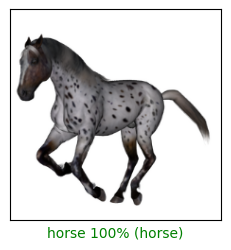

In [31]:
# Visualize the outputs

# you can modify the index value here from 0 to 255 to test different images
index = 8
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()